In [1]:
import pandas as pd
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_colwidth', 500)

import geopandas as gpd
import shapely
import numpy as np
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import nomad.io.base as loader
import nomad.stop_detection.utils as utils
import nomad.stop_detection.hdbscan as HDBSCAN
import nomad.stop_detection.lachesis as LACHESIS
import nomad.stop_detection.ta_dbscan as TADBSCAN
import nomad.stop_detection.grid_based as GRID_BASED # for oracle visits
import nomad.stop_detection.postprocessing as pp

import nomad.visit_attribution as visits
import nomad.filters as filters
import nomad.city_gen as cg

from nomad.contact_estimation import overlapping_visits, compute_visitation_errors, compute_precision_recall_f1

In [2]:
import nomad.city_gen as cg
city = cg.load('../garden-city.pkl')

def classify_building_size_from_id(building_id):
    building = city.buildings.get(building_id)
    n_blocks = len(building.blocks)
    if n_blocks == 1:
        return 'small'
    elif 2 <= n_blocks <= 3:
        return 'medium'
    else:
        return 'big'

def classify_building_type_from_id(building_id):
    building = city.buildings.get(building_id)
    return building.building_type

def classify_dwell(duration):
    if duration <= 5:
        return 'low'
    elif 6 <= duration <= 120:
        return 'mid'
    else:
        return 'high'

In [3]:
def fill_timestamp_gaps(first_time, last_time, pred):
    new_rows = []

    # fill initial gap
    if first_time < pred.loc[0, 'start_timestamp']:
        gap = (pred.loc[0, 'start_timestamp'] - first_time) // 60
        new_rows.append({
            'cluster': None,
            'x': None,
            'y': None,
            'start_timestamp': first_time,
            'duration': gap,
            'building_id': "None"
        })

    # fill intermediate gaps
    for i in range(len(pred) - 1):
        end_time = pred.loc[i, 'start_timestamp'] + pred.loc[i, 'duration'] * 60
        next_start = pred.loc[i + 1, 'start_timestamp']
        
        if end_time < next_start:
            gap = (next_start - end_time) // 60
            new_rows.append({
                'cluster': None,
                'x': None,
                'y': None,
                'start_timestamp': end_time,
                'duration': gap,
                'building_id': "None"
            })

    # fill final gap
    last_end = pred.iloc[-1]['start_timestamp'] + pred.iloc[-1]['duration'] * 60
    if last_end < last_time:
        gap = (last_time - last_end) // 60
        new_rows.append({
            'cluster': None,
            'x': None,
            'y': None,
            'start_timestamp': last_end,
            'duration': gap,
            'building_id': "None"
        })

    df_full = pd.concat([pred, pd.DataFrame(new_rows)], ignore_index=True)
    df_full = df_full.sort_values('start_timestamp').reset_index(drop=True)

    return df_full
    

In [4]:
traj_cols = {'user_id':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}
poi_table = gpd.read_file('../garden_city.gpkg')
# building type
poi_table = poi_table.rename({'type':'building_type'}, axis=1)
# building size
poi_table['building_size'] = poi_table['building_id'].apply(classify_building_size_from_id)

diaries_df = loader.from_file("../../nomad/data/diaries", format="parquet", traj_cols=traj_cols)
diaries_df = diaries_df.rename({'location':'building_id'}, axis=1)
diaries_df = diaries_df.merge(poi_table[['building_id', 'building_size']], on='building_id', how='left')
diaries_df = diaries_df.merge(poi_table[['building_id', 'building_type']], on='building_id', how='left')
diaries_df['dwell_length'] = pd.NA
diaries_df.loc[~diaries_df.building_id.isna(),'dwell_length'] = diaries_df.loc[~diaries_df.building_id.isna(),'duration'].apply(classify_dwell)

sparse_df = loader.from_file("../../nomad/data/sparse_traj/", format="parquet", traj_cols=traj_cols,)

In [5]:
traj_cols = {'user_id':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}

In [15]:
%%time
# user1 = sparse_df.uid.unique()[9]
user1 = 'gracious_babbage'
sparse1 = sparse_df.loc[sparse_df.uid==user1]
# sparse1.loc[:,'x'] = (sparse1['x'] + 4265699)/15
# sparse1.loc[:,'y'] = (sparse1['y'] - 4392976)/15
diary1 = diaries_df.loc[diaries_df.uid == user1]

# to summarize stops after groupby passing through individual locations
summarize_stops_with_loc = partial(utils.summarize_stop, x='x', y='y', keep_col_names=False, passthrough_cols = ['building_id'], complete_output=True) # < function(grouped_data)

# If we want to use 'majority' to attribute visits, then we need stop labels on each ping
labels_hdbscan = HDBSCAN.hdbscan_labels(traj=sparse1,
                                            time_thresh=240,
                                            min_pts=2,
                                            min_cluster_size=3,
                                            traj_cols=traj_cols)
labels_hdbscan.name = 'cluster'
# join with the original data
sparse_with_cluster = sparse1.join(labels_hdbscan)

# has same index as data
pred_hdbscan = visits.point_in_polygon(data=sparse_with_cluster,
                                        poi_table=poi_table,
                                        method='majority',
                                        data_crs='EPSG:3857',
                                        max_distance=15,
                                        user_id='uid',
                                        cluster_label='cluster',
                                        location_id='building_id',
                                        x='x',
                                        y='y')
# join the building id
pred = sparse_with_cluster.join(pred_hdbscan)

# stop_table_hdbscan = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)

stop_table_hdbscan = pp.remove_overlaps(pred,
                                 time_thresh=240,
                                 min_pts=3,
                                 dur_min=5,
                                 traj_cols = traj_cols,
                                 post_processing = 'polygon')

first_time = diary1['timestamp'].iloc[0]
last_time = diary1['timestamp'].iloc[-1] + diary1['duration'].iloc[-1] * 60
filled_stop_hdbscan = fill_timestamp_gaps(first_time, last_time, stop_table_hdbscan)

CPU times: user 824 ms, sys: 8.53 ms, total: 832 ms
Wall time: 832 ms


/var/folders/nt/0tc5pmb17xd73rr4g1xb0g_00000gn/T/ipykernel_80829/2020221460.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_full = pd.concat([pred, pd.DataFrame(new_rows)], ignore_index=True)


In [16]:
print(sum(filled_stop_hdbscan['duration']))
print(sum(diary1['duration']))

20160
20160


In [17]:
overlaps = overlapping_visits(left=filled_stop_hdbscan,
                                      right=diary1,
                                      location_id='building_id',
                                      match_location=False)

errors = compute_visitation_errors(overlaps=overlaps,
                                    true_visits=diary1,
                                    location_id='building_id')

prf1 = compute_precision_recall_f1(overlaps=overlaps,
                                    pred_visits=filled_stop_hdbscan,
                                    true_visits=diary1,
                                    location_id='building_id')

In [18]:
errors

{'missed_fraction': 0.0,
 'merged_fraction': 1.0,
 'split_fraction': 0.008130081300813009}

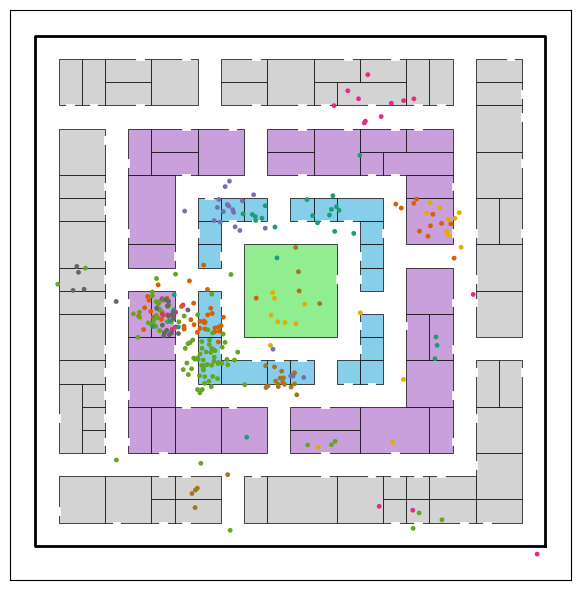

In [12]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=True)

# Plotting Garden City Map
city = cg.load('../garden-city.pkl')
city.plot_city(ax, doors=True, address=False)

# Getting colors for clusters
unique_clusters = sorted(sparse_with_cluster['cluster'].unique())
cluster_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}
del cluster_mapping[-1]
mapped_clusters = sparse_with_cluster['cluster'].map(cluster_mapping).to_numpy()
cmap_base = plt.get_cmap('Dark2', len(unique_clusters) - (1 if -1 in unique_clusters else 0))
# colors = ['gray'] + list(cmap_base.colors)
colors = list(cmap_base.colors)
extended_cmap = mcolors.ListedColormap(colors)

# Plotting Pings
ax.scatter(sparse_with_cluster['x'], 
           sparse_with_cluster['y'], 
           c=mapped_clusters, 
           cmap=extended_cmap, 
           s=6,
           alpha=1,
           zorder=2)

ax.set_yticklabels([])
ax.set_xticklabels([])
# ax.set_title("HDBSCAN Stops for Sample User")
ax.set_xticks([])
ax.set_yticks([])
# ax.set_xlim(12, 22)
# ax.set_ylim(7, 14)
plt.tight_layout()

# plt.savefig('gc_empty.png')
plt.show()

In [12]:
user1 = 'gracious_babbage'
sparse1 = sparse_df.loc[sparse_df.uid==user1]
# sparse1.loc[:,'x'] = (sparse1['x'] + 4265699)/15
# sparse1.loc[:,'y'] = (sparse1['y'] - 4392976)/15
diary1 = diaries_df.loc[diaries_df.uid == user1]

TIME_THRESH=240
DIST_THRESH=25
MIN_PTS=2

labels_tadbscan = TADBSCAN._temporal_dbscan_labels(
                data=sparse1,
                time_thresh=TIME_THRESH,
                dist_thresh=DIST_THRESH,
                min_pts=MIN_PTS,
                traj_cols=traj_cols)

labels_tadbscan.name = 'cluster'
sparse_with_cluster = sparse1.join(labels_tadbscan)

# has same index as data
pred_tadbscan = visits.point_in_polygon(data=sparse_with_cluster,
                                        poi_table=poi_table,
                                        method='majority',
                                        data_crs='EPSG:3857',
                                        max_distance=15,
                                        user_id='uid',
                                        cluster_label='cluster',
                                        location_id='building_id',
                                        x='x',
                                        y='y')
# join the building id
pred_tadbscan = sparse_with_cluster.join(pred_tadbscan)

stop_table_tadbscan = pp.remove_overlaps(pred_tadbscan,
                                 time_thresh=240,
                                 min_pts=3,
                                 dur_min=5,
                                 traj_cols = traj_cols,
                                 post_processing = 'polygon')

first_time = diary1['timestamp'].iloc[0]
last_time = diary1['timestamp'].iloc[-1] + diary1['duration'].iloc[-1] * 60
filled_stop_tadbscan = fill_timestamp_gaps(first_time, last_time, stop_table_tadbscan)

/var/folders/nt/0tc5pmb17xd73rr4g1xb0g_00000gn/T/ipykernel_80829/2020221460.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_full = pd.concat([pred, pd.DataFrame(new_rows)], ignore_index=True)


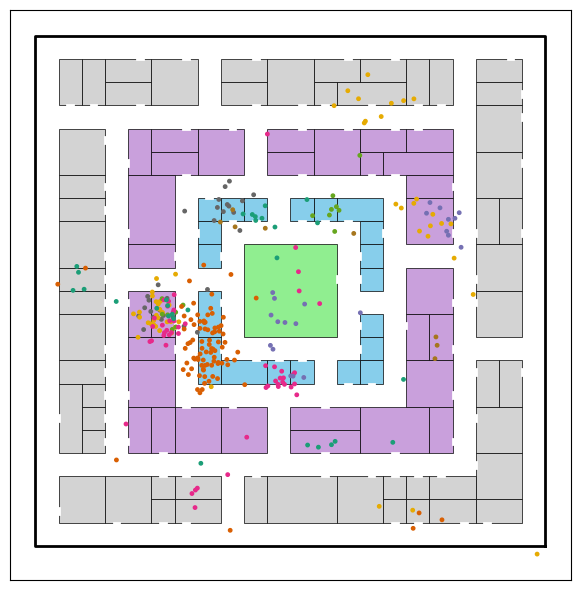

In [14]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=True)

# Plotting Garden City Map
city = cg.load('../garden-city.pkl')
city.plot_city(ax, doors=True, address=False)

# Getting colors for clusters
unique_clusters = sorted(sparse_with_cluster['cluster'].unique())
cluster_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}
del cluster_mapping[-1]
mapped_clusters = sparse_with_cluster['cluster'].map(cluster_mapping).to_numpy()
cmap_base = plt.get_cmap('Dark2', len(unique_clusters) - (1 if -1 in unique_clusters else 0))
# colors = ['gray'] + list(cmap_base.colors)
colors = list(cmap_base.colors)
extended_cmap = mcolors.ListedColormap(colors)

# Plotting Pings
ax.scatter(sparse_with_cluster['x'], 
           sparse_with_cluster['y'], 
           c=mapped_clusters, 
           cmap=extended_cmap, 
           s=6,
           alpha=1,
           zorder=2)

ax.set_yticklabels([])
ax.set_xticklabels([])
# ax.set_title("HDBSCAN Stops for Sample User")
ax.set_xticks([])
ax.set_yticks([])
# ax.set_xlim(12, 22)
# ax.set_ylim(7, 14)
plt.tight_layout()

# plt.savefig('gc_empty.png')
plt.show()

In [61]:
print(len(filled_stop_tadbscan))

49


In [13]:
overlaps = overlapping_visits(left=stop_table_tadbscan,
                                      right=diary1,
                                      location_id='building_id',
                                      match_location=False)

errors = compute_visitation_errors(overlaps=overlaps,
                                    true_visits=diary1,
                                    location_id='building_id')

prf1 = compute_precision_recall_f1(overlaps=overlaps,
                                    pred_visits=stop_table_tadbscan,
                                    true_visits=diary1,
                                    location_id='building_id')

In [14]:
errors

{'missed_fraction': 0.8048780487804879,
 'merged_fraction': 0.016260162601626018,
 'split_fraction': 0.008130081300813009}

In [ ]:
testing_df = all_metrics_df[all_metrics_df["algorithm"].isin(["ta-dbscan", "hdbscan"])]
pivoted = testing_df.pivot(index="user", columns="algorithm", values="merged_fraction")
pivoted = pivoted.dropna(subset=["ta-dbscan", "hdbscan"])
users_hdbscan_more_merged = pivoted[pivoted["hdbscan"] > pivoted["ta-dbscan"]].index.tolist()

users_hdbscan_more_merged